In [1]:
import gzip            # can uncompress gzipped files, useful for accessing the pleiades data
import io              # useful routines for input/output
import numpy as np
import pandas as pd    # for working with "rows/columns" oriented data
import pymysql.cursors # 
import sqlite3         # an SQL database
import urllib.request  # for loading documents using http
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib.ticker import MaxNLocator

# Connect to the database
connection = pymysql.connect(host='hosting.nyu.edu',
                             user='cmrougha_adsq',
                             password='###REPLACE###',
                             db='cmrougha_adsq2017',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

In [2]:
sql = """
SELECT *
 FROM `17.4.5_pinAstr_all`
"""

with connection.cursor() as cursor:

    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

df = pd.DataFrame(result, columns = names)

# The New Collections

Several authors and collections in various genres were selected to compare with the supposed Little Astronomy. These include:

* The works of Galen (largely medical)
   * Ordered 'collections' of his corpus found in *On My Own Books*, *On the Order of My Books*, the Alexandrian Canon, Hunayn ibn Ishaq's *Risala*
   * A main text to trace is *On the Sects*, which is typically placed first
* Plato's tetralogies
   * E.g. the first: *Euthyphro*, *Apology*, *Crito*, *Phaedo*
* The Alexandrian canon of orators
   * Aeschines, Andocides, Antiphon, Demosthenes, Dinarchus, Hypereides, Isaeus, Isocrates, Lycurgus, Lysias
* Tragedy and trilogies
   * *Agamemnon*, *Choephoroe*, *Eumenides*
   * *Oedipus tyrannus*, *Oedipus Coloneus*, *Antigone*
   
Additionally, as a counterpoint to organized collections, several individual texts or authors have also been selected:

* Apollonius, *Argonautica*
* "Homer", *Batrachomyomachia*
* Nicander, *Theriaca*
* Thucydides, *Historiae*
* Lucian
* Dionysius Thrax, *Grammatica*
* Aelian, *Tactica*
* Gorgias, *Helen*

In [25]:
sql = """
SELECT *
 FROM `astrID_pinID_au`
"""
with connection.cursor() as cursor:
    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()
au = pd.DataFrame(result, columns = names)

sql = """
SELECT *
 FROM `astrID_pinID_wo`
"""
with connection.cursor() as cursor:
    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()
wo = pd.DataFrame(result, columns = names)

sql = """
SELECT *
 FROM `astrID_pinID_ms`
"""
with connection.cursor() as cursor:
    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()
ms = pd.DataFrame(result, columns = names)

sql = """
SELECT *
 FROM `astrID_pinID_wi`
"""
with connection.cursor() as cursor:
    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()
wi = pd.DataFrame(result, columns = names)

print("The current dataset includes %s authors." % str(len(au)))
print("The current dataset includes %s works." % str(len(wo)))
print("The current dataset includes %s manuscripts." % str(len(ms)))
print("The current dataset includes %s witnesses." % str(len(wi)))

The current dataset includes 1154 authors.
The current dataset includes 4103 works.
The current dataset includes 1738 manuscripts.
The current dataset includes 16347 witnesses.


## A Problem

No flags went up when going through the workflow to bring the new Pinakes data into my dataset, but the following attempted visualization revealed that not everything had come through:

In [4]:
sql = """
SELECT *
 FROM `17.4.5_pinAstr_all`
"""

with connection.cursor() as cursor:

    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

df = pd.DataFrame(result, columns = names)

,witness,astrID_wi,MS,astrID_ms,Pays,Ville,Depot,Fonds,Cote,Order,...,Identifiant,Recension,BHG,DateLit.,Siècle,Date,Commentaire,Contenu,Rev.,Bibliographies
0,11501_4,1619935,4,4616490,France,Agen,Bibliothèque municipale,fonds principal,20,4,...,,,,,16,,Excerpta quaedam,,,
1,11501_4,1619935,4,4616490,France,Agen,Bibliothèque municipale,fonds principal,20,12,...,,,,,16,,Cum scholiis in margine et glossis inter linea...,,,
2,10377_4,3418395,4,4616490,France,Agen,Bibliothèque municipale,fonds principal,20,8,...,,,,,,,"titre: Dionysii Catonis disticha moralia, grae...",,P,
3,6755_4,7490161,4,4616490,France,Agen,Bibliothèque municipale,fonds principal,20,5,...,,,,,16,,Cum scholiis marginalibus et glossis inter lineas,,,
4,6755_4,7490161,4,4616490,France,Agen,Bibliothèque municipale,fonds principal,20,6,...,,,,,16,,Sententiae ex Euripidis Hecuba,,,


In [16]:
# WITNESS CORRELATIONS
def witnessCorr(df,texts1_toExamine,texts2_toExamine,number_context,number_range,givenTitle):
    '''
    An adjustment of the old witness correlations, still in progress
    '''
    # Calculates the default value if number_range is not provided.
    if number_range is None:
        #number_range = min(list(df[number_context])),max(list(df[number_context]))
        number_range = 0,0
    
    # Obtains data for correlation counts between the two lists of texts from the dataframe.
    correlations = dict()
    for text1 in texts1_toExamine:
        authorText1 = str(text1[0]) + ' ' + str(text1[1])
        correlations[authorText1] = dict()
        pin1_present = list(df['MS'][((df['Auteur'] == text1[0])&(df['Oeuvre'] == text1[1]))])
        for i in range(number_range[0],number_range[1]+1):
            correlations[authorText1][i] = list()
            for text2 in texts2_toExamine:
                authorText2 = str(text2[0]) + ' ' + str(text2[1])
                pin2_present = list(df['MS'][((df['Auteur'] == text2[0])&(df['Oeuvre'] == text2[1]))])
                if text1 != text2: 
                    count = 0
                    for pin1 in pin1_present:
                        if pin1 in pin2_present:
                            count = count + df[['MS','Auteur','Oeuvre']][((df['MS'] == pin1)&(df['Auteur'] == text1[0])&(df['Oeuvre'] == text1[1]))].count()[0]
                    correlations[authorText1][i].append((authorText2,int(count)))
                        
    # Inputs data into the variables that will be used for the graph.
    # The entire graph construction is contained within a for loop, since we will be producing a variable
    # number of graphs, depending on how many input texts were provided.
    for text1 in texts1_toExamine:
        authorText1 = str(text1[0]) + ' ' + str(text1[1])
        titles = []
        witnesses = dict()
        for i in range(number_range[0],number_range[1]+1):
            witnesses[i] = list()

        for corr in correlations[authorText1][number_range[0]]:
            titles.append(corr[0])
        
        for i in range(number_range[0],number_range[1]+1):
            for corr in correlations[authorText1][i]:
                witnesses[i].append(corr[1])

        y_pos = np.arange(len(titles))    # the x locations for the groups
        width = 0.35                      # the width of the bars: can also be len(x) sequence

        bar_sections = dict()
        lists_of_lists = list()
        for key in witnesses:
            lists_of_lists.append(witnesses[key])

        # The colors list is finite -- if a context ever has enough values to require more than this list, 
        # I might add a random color generator for the upper values. (Downside: might randomly generate
        # colors that are similar and hard to distinguish next to each other.)
        colors = ('#000000','#991515','#ff0000','#ff7700','#ffe100','#ddff00','#66ed00','#00bc00','#00bc71','#00bcbc','#006dbc','#0300bc','#8300ff','#e500ff','#ff28d0','#ff77ad','#ffc6c6','#ffffff','#000000')
        
        for i in range(number_range[0],number_range[1]+1):
            if i == number_range[0]:
                bar_sections[i] = plt.barh(y_pos, witnesses[i], width, color=colors[i])
            elif i == number_range[0]+1:
                bar_sections[i] = plt.barh(y_pos, witnesses[i], width, color=colors[i], left=witnesses[i-1])
            else:
                bar_sections[i] = plt.barh(y_pos, witnesses[i], width, color=colors[i], left=[sum(x) for x in zip(*lists_of_lists[0:i])])

        list_of_sections = list()
        for section in bar_sections:
            list_of_sections.append(bar_sections[section][0])
        list_of_legendText = list()
        for section in bar_sections:
            list_of_legendText.append(str(section))

        plt.yticks(y_pos, titles)
        plt.xlabel('Number of Witnesses overlapping with ' + authorText1)
        plt.title(givenTitle)

        ax = plt.subplot(111)
           
        yield plt.show() 

                    


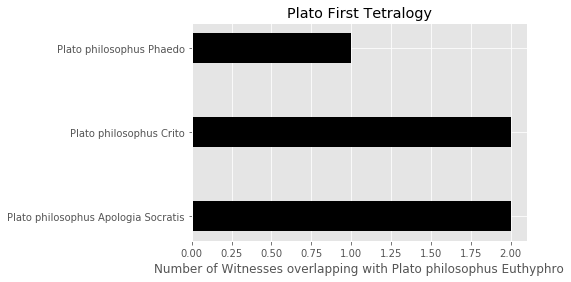

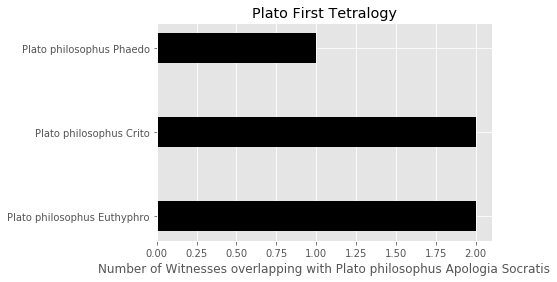

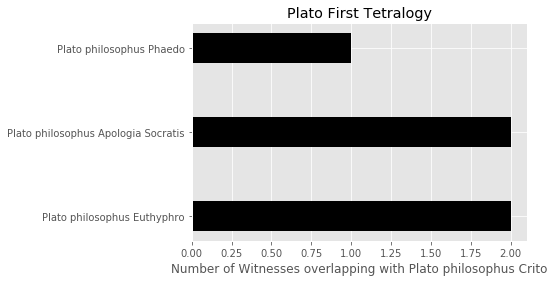

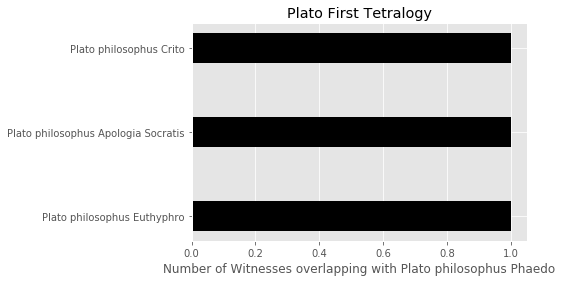

In [17]:
texts1_toExamine = (('Plato philosophus','Euthyphro'),('Plato philosophus','Apologia Socratis'),('Plato philosophus','Crito'),('Plato philosophus','Phaedo'))
texts2_toExamine = (('Plato philosophus','Euthyphro'),('Plato philosophus','Apologia Socratis'),('Plato philosophus','Crito'),('Plato philosophus','Phaedo'))
number_context = None
givenTitle = 'Plato First Tetralogy'

graph_generator = witnessCorr(df,texts1_toExamine,texts2_toExamine,number_context,None,givenTitle)

for graph in graph_generator:
    graph

In [19]:
sql = """
SELECT *
 FROM `17.4.5_pinAstr_all`
 WHERE Oeuvre = "Phaedo"
"""

with connection.cursor() as cursor:

    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

phaedo = pd.DataFrame(result, columns = names)
phaedo

,witness,astrID_wi,MS,astrID_ms,Pays,Ville,Depot,Fonds,Cote,Order,...,Identifiant,Recension,BHG,DateLit.,Siècle,Date,Commentaire,Contenu,Rev.,Bibliographies
0,11451_14971,6808326,14971,6386326,España,Escorial (El-),Real Biblioteca,fonds principal,?. I. 13 (Andrés 355),66,...,,,,,13-14,,,,,


Compare this with the [Pinakes page](http://pinakes.irht.cnrs.fr/notices/oeuvre/11451/) for Plato's *Phaedo* and it is clear that material was lost in the conversion. But a consistent pattern does not seem to be apparent, since other texts went through conversion without an issue:

In [21]:
sql = """
SELECT *
 FROM `17.4.5_pinAstr_all`
 WHERE Oeuvre = "Batrachomyomachia"
"""

with connection.cursor() as cursor:

    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

batrach = pd.DataFrame(result, columns = names)
batrach

,witness,astrID_wi,MS,astrID_ms,Pays,Ville,Depot,Fonds,Cote,Order,...,Identifiant,Recension,BHG,DateLit.,Siècle,Date,Commentaire,Contenu,Rev.,Bibliographies
0,3907_16660,2620316,16660,3738082,Italia,Firenze,Biblioteca Medicea Laurenziana,Plut.,74. 05,10,...,,,,,12,,,,Biblio,
1,3907_16666,6044892,16666,3902249,Italia,Firenze,Biblioteca Medicea Laurenziana,Plut.,74. 11,9,...,,,,,13,,,,,R(III)0996
2,3907_43360,8581922,43360,3680300,Italia,Modena,Biblioteca Estense universitaria,fonds principal,?. P. 5. 20 (Puntoni 109),5,...,,,,,15,,,,,
3,3907_43676,7837740,43676,4598850,Rossijskaja Federacija,Moskva,Gosudarstvennyj Istori?eskij Musej (GIM),Sinod. gr.,051 (Vlad. 464),1,...,,,,,14 med.,,,Titulus initialis ??????? ???? ???????? ???? ...,,R(III)1736
4,3907_43908,1904115,43908,6378934,Rossijskaja Federacija,Moskva,Gosudarstvennyj Istori?eskij Musej (GIM),Sinod. gr.,283 (Vlad. 466),1,...,,,,,15-16,,,,,
5,3907_51509,3041816,51509,3782145,France,Paris,Bibliothèque nationale de France (BNF),gr.,1883,2,...,,,,,14,,,,,R(III)0192
6,3907_52806,6337766,52806,9844846,France,Paris,Bibliothèque nationale de France (BNF),suppl. gr.,35,15,...,,,,,15 ex.,,,,,R(III)1913a
7,3907_53369,8969563,53369,9183449,France,Paris,Bibliothèque nationale de France (BNF),suppl. gr.,634,1,...,,,,,14,,,,,R(III)0192
8,3907_65931,4561863,65931,2361626,Vaticano,Vaticano,Biblioteca Apostolica Vaticana,Pal. gr.,199,6,...,,,,,13-14,1300 ca.,,,,
9,3907_66029,9368279,66029,1705221,Vaticano,Vaticano,Biblioteca Apostolica Vaticana,Pal. gr.,297,6,...,,,,,15-16,,"Tractatus e empiricis et methodicis, ex GALENI...",Incipit ?? ?'???? ??????? ??? ?? ??????????,,R(III)0817


In [22]:
sql = """
SELECT *
 FROM `17.4.5_pinAstr_all`
 WHERE Oeuvre = "De sectis ad eos qui introducuntur"
"""

with connection.cursor() as cursor:

    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

sects = pd.DataFrame(result, columns = names)
sects

,witness,astrID_wi,MS,astrID_ms,Pays,Ville,Depot,Fonds,Cote,Order,...,Identifiant,Recension,BHG,DateLit.,Siècle,Date,Commentaire,Contenu,Rev.,Bibliographies
0,3907_16660,2620316,16660,3738082,Italia,Firenze,Biblioteca Medicea Laurenziana,Plut.,74. 05,10,...,,,,,12,,,,Biblio,
1,3907_16666,6044892,16666,3902249,Italia,Firenze,Biblioteca Medicea Laurenziana,Plut.,74. 11,9,...,,,,,13,,,,,R(III)0996
2,3907_43360,8581922,43360,3680300,Italia,Modena,Biblioteca Estense universitaria,fonds principal,?. P. 5. 20 (Puntoni 109),5,...,,,,,15,,,,,
3,3907_43676,7837740,43676,4598850,Rossijskaja Federacija,Moskva,Gosudarstvennyj Istori?eskij Musej (GIM),Sinod. gr.,051 (Vlad. 464),1,...,,,,,14 med.,,,Titulus initialis ??????? ???? ???????? ???? ...,,R(III)1736
4,3907_43908,1904115,43908,6378934,Rossijskaja Federacija,Moskva,Gosudarstvennyj Istori?eskij Musej (GIM),Sinod. gr.,283 (Vlad. 466),1,...,,,,,15-16,,,,,
5,3907_51509,3041816,51509,3782145,France,Paris,Bibliothèque nationale de France (BNF),gr.,1883,2,...,,,,,14,,,,,R(III)0192
6,3907_52806,6337766,52806,9844846,France,Paris,Bibliothèque nationale de France (BNF),suppl. gr.,35,15,...,,,,,15 ex.,,,,,R(III)1913a
7,3907_53369,8969563,53369,9183449,France,Paris,Bibliothèque nationale de France (BNF),suppl. gr.,634,1,...,,,,,14,,,,,R(III)0192
8,3907_65931,4561863,65931,2361626,Vaticano,Vaticano,Biblioteca Apostolica Vaticana,Pal. gr.,199,6,...,,,,,13-14,1300 ca.,,,,
9,3907_66029,9368279,66029,1705221,Vaticano,Vaticano,Biblioteca Apostolica Vaticana,Pal. gr.,297,6,...,,,,,15-16,,"Tractatus e empiricis et methodicis, ex GALENI...",Incipit ?? ?'???? ??????? ??? ?? ??????????,,R(III)0817


In [39]:
df[['MS','Oeuvre','Auteur']][df['Auteur'] == 'Aeschylus']

,MS,Oeuvre,Auteur
111,1466,Prometheus uinctus,Aeschylus
122,3352,Septem contra Thebas,Aeschylus
123,3352,Prometheus uinctus,Aeschylus
283,6540,Prometheus uinctus,Aeschylus
376,6939,Opera,Aeschylus
396,7001,Septem contra Thebas,Aeschylus
397,7001,Prometheus uinctus,Aeschylus
622,9715,Supplices,Aeschylus
623,9715,Septem contra Thebas,Aeschylus
624,9715,Prometheus uinctus,Aeschylus


It seems something went wrong when I adjusted the workflow to automatically obtain every text for a given author.

# Finding Digitized MSS

The following code was able to go through the HTML files and grab all links in Pinakes to digitized manuscripts.

In [ ]:
# -*- coding: utf-8 -*-

from bs4 import BeautifulSoup
import os
from os import listdir

#texts = ["51974.html"]
texts = listdir("mss-downloaded")

TSVdigitized = "pinID\tRepository\tURL"

for text in texts:
    if '.html' in text:
        inFile = open("mss-downloaded/" + text, errors='replace')
        rawText = inFile.read()
        inFile.close()
        
        if "Identifiants :" in rawText:
            rawText = rawText.split("<h3>Identifiants :</h3>")[1]
            rawText = rawText.split("</div>")[0]
            rawText = rawText.strip()
            
            
            soup = BeautifulSoup(rawText, 'html.parser')
            
            #print(soup.prettify())
            
            cells = soup.find_all('td')
            #print(cells)
            
            count = 0
            for td in cells:
                if "numérisation" in str(td):
                    TSVdigitized = TSVdigitized + "\n" + text[:-5] + "\t" + td.string + "\t" + cells[count + 2].a.get('href')
                    count += 1
                elif " num." in str(td) and "num.)" not in str(td):
                    TSVdigitized = TSVdigitized + "\n" + text[:-5] + "\t" + td.string + "\t" + cells[count + 2].a.get('href')
                    count += 1
                else:
                    count += 1
                    
print(TSVdigitized)

outFile = open("tsvDigitized.tsv", "w")
outFile.write(TSVdigitized)
outFile.close()

While the issues above show that not all manuscripts are properly incorporated into the dataset yet, of the 1738 manuscripts currently included 488 have digital versions. Of the 151 manuscripts containing texts from the Little Astronomy, only 19 currently have digital versions according to Pinakes.